# Q1.

C:\Users\DELL\AppData\Local\Temp\ipykernel_11024\1021695739.py:98: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(mf, x)
C:\Users\DELL\AppData\Local\Temp\ipykernel_11024\1021695739.py:101: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(mf * x, x) / area


Temperature 5 → Fan speed 0.00
Temperature 30 → Fan speed 0.00
Temperature 50 → Fan speed 30.00
Temperature 65 → Fan speed 50.00
Temperature 75 → Fan speed 70.00
Temperature 85 → Fan speed 92.22
Temperature 95 → Fan speed 93.33


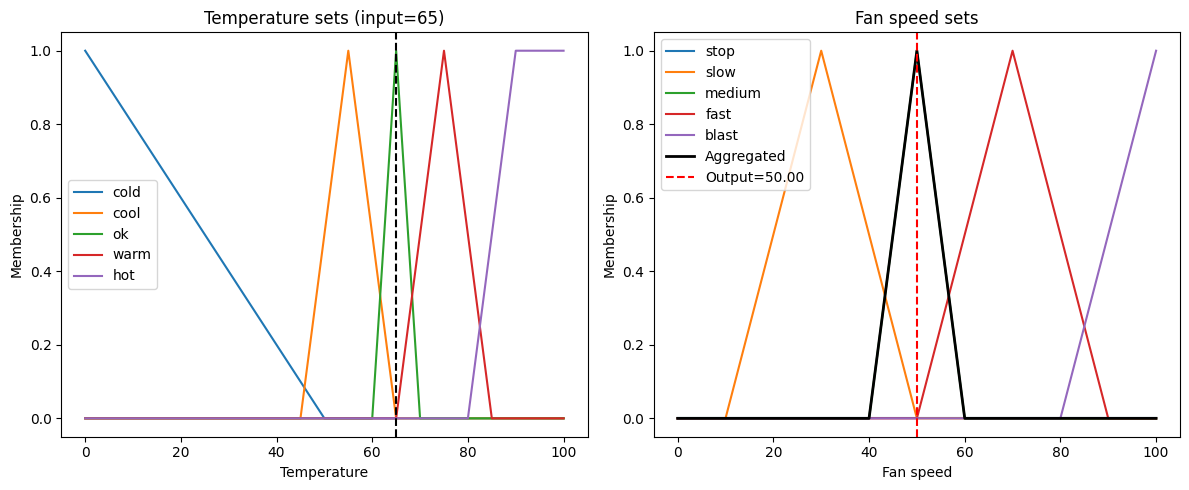

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Membership functions
# ------------------------------
def tri(x, a, b, c):
    """Triangular membership function."""
    x = np.asarray(x, dtype=float)
    y = np.zeros_like(x)
    left = (x >= a) & (x <= b)
    right = (x >= b) & (x <= c)
    if b != a:
        y[left] = (x[left] - a) / (b - a)
    if c != b:
        y[right] = (c - x[right]) / (c - b)
    return y

def left_shoulder(x, b, c):
    """Left-shoulder membership (value=1 below b, decreases to 0 at c)."""
    x = np.asarray(x, dtype=float)
    y = np.zeros_like(x)
    y[x <= b] = 1.0
    mask = (x > b) & (x <= c)
    y[mask] = (c - x[mask]) / (c - b)
    return y

def right_shoulder(x, a, b):
    """Right-shoulder membership (value=0 below a, increases to 1 at b and beyond)."""
    x = np.asarray(x, dtype=float)
    y = np.zeros_like(x)
    mask = (x >= a) & (x < b)
    if b != a:
        y[mask] = (x[mask] - a) / (b - a)
    y[x >= b] = 1.0
    return y

# ------------------------------
# Domains
# ------------------------------
temp_x = np.linspace(0, 100, 1001)   # Temperature domain
fan_x  = np.linspace(0, 100, 1001)   # Fan speed domain

# ------------------------------
# Fuzzy sets for Temperature
# ------------------------------
temp_sets = {
    "cold":  left_shoulder(temp_x, b=0, c=50),
    "cool":  tri(temp_x, 45, 55, 65),
    "ok":    tri(temp_x, 60, 65, 70),   # just right
    "warm":  tri(temp_x, 65, 75, 85),
    "hot":   right_shoulder(temp_x, a=80, b=90)
}

# ------------------------------
# Fuzzy sets for Fan Speed
# ------------------------------
fan_sets = {
    "stop":  tri(fan_x, 0, 0, 0),
    "slow":  tri(fan_x, 10, 30, 50),
    "medium":tri(fan_x, 40, 50, 60),
    "fast":  tri(fan_x, 50, 70, 90),
    "blast": right_shoulder(fan_x, a=80, b=100)
}

# ------------------------------
# Rule Base
# ------------------------------
rules = [
    ("cold",  "stop"),
    ("cool",  "slow"),
    ("ok",    "medium"),
    ("warm",  "fast"),
    ("hot",   "blast")
]

# ------------------------------
# Fuzzification
# ------------------------------
def fuzzify_temp(t):
    return {name: np.interp(t, temp_x, mf) for name, mf in temp_sets.items()}

# ------------------------------
# Inference
# ------------------------------
def infer_fan_membership(t):
    temp_mf = fuzzify_temp(t)
    aggregated = np.zeros_like(fan_x)
    for tname, fanname in rules:
        strength = temp_mf[tname]
        aggregated = np.maximum(aggregated, np.minimum(strength, fan_sets[fanname]))
    return aggregated

# ------------------------------
# Defuzzification (Centroid)
# ------------------------------
def defuzzify_centroid(mf, x):
    area = np.trapz(mf, x)
    if area == 0:
        return 0.0
    return np.trapz(mf * x, x) / area

# ------------------------------
# Full Controller
# ------------------------------
def compute_fan_speed(t, show_plot=True):
    aggr = infer_fan_membership(t)
    crisp = defuzzify_centroid(aggr, fan_x)

    if show_plot:
        plt.figure(figsize=(12,5))

        # Plot temperature sets
        plt.subplot(1,2,1)
        for name, mf in temp_sets.items():
            plt.plot(temp_x, mf, label=name)
        plt.axvline(t, color="k", linestyle="--")
        plt.title(f"Temperature sets (input={t})")
        plt.xlabel("Temperature")
        plt.ylabel("Membership")
        plt.legend()

        # Plot fan speed sets + aggregated
        plt.subplot(1,2,2)
        for name, mf in fan_sets.items():
            plt.plot(fan_x, mf, label=name)
        plt.plot(fan_x, aggr, "k", linewidth=2, label="Aggregated")
        plt.axvline(crisp, color="r", linestyle="--", label=f"Output={crisp:.2f}")
        plt.title("Fan speed sets")
        plt.xlabel("Fan speed")
        plt.ylabel("Membership")
        plt.legend()

        plt.tight_layout()
        plt.show()

    return crisp

# ------------------------------
# Example Run
# ------------------------------
if __name__== "__main__":
    test_temps = [5, 30, 50, 65, 75, 85, 95]
    for t in test_temps:
        crisp = compute_fan_speed(t, show_plot=False)
        print(f"Temperature {t} → Fan speed {crisp:.2f}")

    # Show plot for one example
    compute_fan_speed(65,show_plot=True)

# Q2.

Gen   0 | Best x=30 f= 900 | Mean f= 273.80
Gen   1 | Best x=31 f= 961 | Mean f= 403.40
Reached optimal solution.

=== GA Result ===
Best chromosome (bits): 11111
Decoded x: 31
Fitness f(x)=x^2: 961


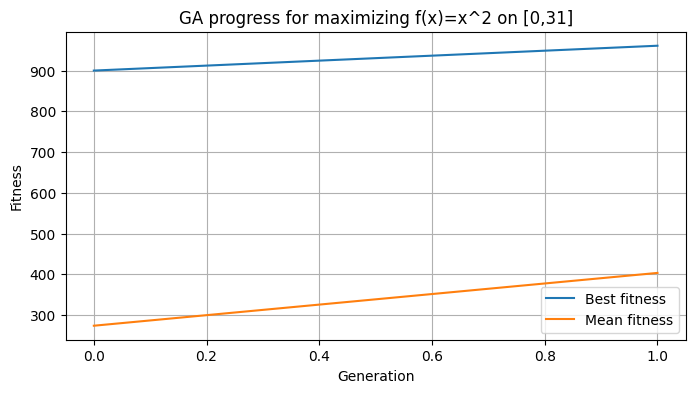

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt

# ---------- Problem settings ----------
MIN_X = 0
MAX_X = 31           # range [0,31]
N_BITS = 5           # 2^5 = 32 values -> encodes 0..31 exactly
POP_SIZE = 30
TOURNAMENT_SIZE = 3
CROSSOVER_RATE = 0.9
MUTATION_RATE = 1.0 / N_BITS   # per-bit mutation probability
ELITISM = True
MAX_GENERATIONS = 100
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ---------- Helper functions ----------
def int_to_bits(n, bits=N_BITS):
    """Convert integer n to binary list of length bits (MSB first)."""
    return [int(b) for b in format(n, f'0{bits}b')]

def bits_to_int(bitlist):
    """Convert binary list (MSB first) to integer."""
    return int("".join(str(int(b)) for b in bitlist), 2)

def decode(chromosome):
    """Decode chromosome (bit list) to integer x in [MIN_X, MAX_X]."""
    val = bits_to_int(chromosome)
    # direct mapping since 0..31 maps to 0..31
    return val

def fitness_of(x):
    """Fitness function f(x) = x^2 (we maximize)."""
    return x * x

# ---------- Genetic operators ----------
def random_chromosome():
    return [random.choice([0,1]) for _ in range(N_BITS)]

def create_initial_population(size=POP_SIZE):
    return [random_chromosome() for _ in range(size)]

def tournament_selection(pop, fitnesses, k=TOURNAMENT_SIZE):
    """Return selected chromosome (copy) by tournament selection."""
    participants = random.sample(range(len(pop)), k)
    best = max(participants, key=lambda i: fitnesses[i])
    return pop[best].copy()

def single_point_crossover(a, b):
    if len(a) != len(b):
        raise ValueError("Chromosomes must have same length for crossover")
    point = random.randint(1, len(a)-1)
    child1 = a[:point] + b[point:]
    child2 = b[:point] + a[point:]
    return child1, child2

def mutate(chrom):
    for i in range(len(chrom)):
        if random.random() < MUTATION_RATE:
            chrom[i] = 1 - chrom[i]

# ---------- GA run ----------
def run_ga():
    pop = create_initial_population()
    history_best = []
    history_mean = []

    for gen in range(MAX_GENERATIONS):
        # Evaluate fitnesses
        decoded = [decode(ind) for ind in pop]
        fitnesses = [fitness_of(x) for x in decoded]

        # Stats
        best_idx = int(np.argmax(fitnesses))
        best_fit = fitnesses[best_idx]
        best_x = decoded[best_idx]
        mean_fit = float(np.mean(fitnesses))
        history_best.append(best_fit)
        history_mean.append(mean_fit)

        print(f"Gen {gen:3d} | Best x={best_x:2d} f={best_fit:4d} | Mean f={mean_fit:7.2f}")

        # Termination: perfect solution found
        if best_fit >= MAX_X * MAX_X:
            print("Reached optimal solution.")
            break

        # Create next generation
        new_pop = []

        # Elitism: copy best individual to next generation
        if ELITISM:
            new_pop.append(pop[best_idx].copy())

        # Fill rest of population
        while len(new_pop) < POP_SIZE:
            # Selection
            parent1 = tournament_selection(pop, fitnesses)
            parent2 = tournament_selection(pop, fitnesses)

            # Crossover
            if random.random() < CROSSOVER_RATE:
                child1, child2 = single_point_crossover(parent1, parent2)
            else:
                child1, child2 = parent1.copy(), parent2.copy()

            # Mutation
            mutate(child1)
            mutate(child2)

            new_pop.append(child1)
            if len(new_pop) < POP_SIZE:
                new_pop.append(child2)

        pop = new_pop

    # Final evaluation & return best
    decoded = [decode(ind) for ind in pop]
    fitnesses = [fitness_of(x) for x in decoded]
    best_idx = int(np.argmax(fitnesses))
    best_chrom = pop[best_idx]
    best_x = decoded[best_idx]
    best_fit = fitnesses[best_idx]

    return {
        "best_x": best_x,
        "best_fitness": best_fit,
        "best_chromosome": best_chrom,
        "history_best": history_best,
        "history_mean": history_mean
    }

# ---------- Run when executed ----------
if __name__== "__main__":
    result = run_ga()
    print("\n=== GA Result ===")
    print("Best chromosome (bits):", "".join(str(b) for b in result["best_chromosome"]))
    print("Decoded x:", result["best_x"])
    print("Fitness f(x)=x^2:", result["best_fitness"])

    # Plot progress
    plt.figure(figsize=(8,4))
    plt.plot(result["history_best"], label="Best fitness")
    plt.plot(result["history_mean"], label="Mean fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("GA progress for maximizing f(x)=x^2 on [0,31]")
    plt.legend()
    plt.grid(True)
    plt.show()